This notebook looks at creating a figure showing the distribution of the train, test and calibration countries (Figure 2B). It also includes code for training, evaluating and performing inference for canopy height and associated uncertainty.

### Step 1: Import packages

In [6]:
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

from sklearn.model_selection import train_test_split
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import os
from tqdm.auto import tqdm
from shapely.geometry import Point

### Create a publication-ready figure for the train-test-calibration split for GEDI (Figure 2B)

In [20]:
# Planet data- get first biannual image in 2020
planet = ee.ImageCollection("projects/planet-nicfi/assets/basemaps/africa")
monthlyPlanet = planet.filterDate('2020-01-01', '2021-01-01').filter(ee.Filter.eq('cadence','biannual')).first()

# Get a geometry of the africa countries that intersect with the extent of the planet image
africa_countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")\
    .filter(ee.Filter.eq('wld_rgn', 'Africa'))\
    .filterBounds(monthlyPlanet.geometry()).map(lambda c: c.intersection(monthlyPlanet.geometry(), 100))

# Get list of country names
country_list = africa_countries.aggregate_array('country_na').getInfo()

In [21]:
# Split country names into train, test and calibration countries
train, test, _, _ = train_test_split(country_list, country_list, test_size=0.2, random_state=42)
train, calibration, _, _ = train_test_split(train, train, test_size=0.2, random_state=42)

print('Train countries:', len(train))
print('Test countries:',len(test))
print('Calibration countries:',len(calibration))


Train countries: 35
Test countries: 12
Calibration countries: 9


In [22]:
# Filter countries by split and then convert to a geodataframe
train_countries = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(africa_countries).filter(ee.Filter.inList('country_na', train)),
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })
test_countries = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(africa_countries).filter(ee.Filter.inList('country_na', test)),
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })
calibration_countries = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(africa_countries).filter(ee.Filter.inList('country_na', calibration)),
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
    })

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
train_countries.crs = 'EPSG:4326'
test_countries.crs = 'EPSG:4326'
calibration_countries.crs = 'EPSG:4326'

In [24]:
# Manually construct a point
point_geometry = Point((
        19.250142136823992,
        -33.86456151224325
))

# Create a GeoDataFrame with the point geometry
data = {'geometry': [point_geometry]}
point = gpd.GeoDataFrame(data, geometry='geometry')

### Create Figure

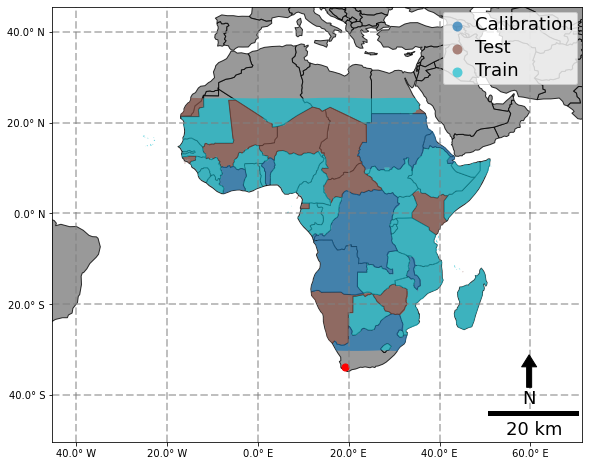

In [43]:
from matplotlib.lines import Line2D

train_countries['Cal'] = 'Train'
test_countries['Cal'] = 'Test'
calibration_countries['Cal'] = 'Calibration'
gdf = pd.concat([test_countries, train_countries, calibration_countries], ignore_index=True)

# Create a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 8), alpha=0.8, color='grey', edgecolor='k')
# ax = plt.axes(projection=ccrs.Mercator())

# Extract the bounding box coordinates from the GeoDataFrame
bounds = gdf.geometry.total_bounds
# Add extra width to the bounding box (adjust the value based on your preference)
extra_width = 20  # You can adjust this value
bounds_with_extra_width = [
    bounds[0] - extra_width,
    bounds[1] - extra_width,
    bounds[2] + extra_width,
    bounds[3] + extra_width
]

# Set the x and y limits based on the adjusted bounding box coordinates
ax.set_xlim(bounds_with_extra_width[0], bounds_with_extra_width[2])
ax.set_ylim(bounds_with_extra_width[1], bounds_with_extra_width[3])

# Assuming you have defined dwCal_gdf and dwTest_gdf GeoDataFrames
gdf.plot(column = 'Cal', ax =ax, alpha=0.7, legend =True)
point.plot(ax = ax, color = 'Red', markersize=50, label='Local area of interest')

# Customize the legend
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))  # Adjust the legend position
for label in legend.get_texts():
    label.set_fontsize(18)  # Set font size for legend labels

# Add a scale bar
scalebar = ScaleBar(1, location='lower right', units='km')
scalebar.font_properties.set_size(18)  # Set the font size
ax.add_artist(scalebar)

# Add North Arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=18,
            xycoords=ax.transAxes)

# add gridlines and coords
ax.grid(True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Format the x and y axes with latitude and longitude
def format_lon(value, pos):
    direction = 'N' if value >= 0 else 'S'
    return f'{abs(value)}° {direction}'
def format_lat(value, pos):
    direction = 'E' if value >= 0 else 'W'
    return f'{abs(value)}° {direction}'

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(x, _)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(y, _)))

# Display the map
# plt.show()

# Save the map to an image file
plt.savefig(r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\GEDI_sampleCountries.png', bbox_inches='tight', pad_inches=0.1, dpi=350, transparent=True)

### Prepare data for modelling
The data was extracted on a country basis, for each country in each of the three splits, the data was combined into a single file and written to a feather file. Feather files are a binary format for storing data frames in Python. They are fast, require less memory than CSV files, and can be read by pandas.

In [ ]:
# Combine height csv files according to random split of countries
def read_and_write_to_feather(country_list, feather_filename):
    # Assume CSV files are in subdirectories named after country names
    base_directory = r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\subAfrica"  # Replace with your actual path

    # Initialize an empty DataFrame to store the combined data
    combined_data = pd.DataFrame()

    # Loop through each country in the list
    for country in tqdm(country_list):
        # Create the path to the CSV file for the current country
        csv_path = os.path.join(base_directory, country, "height1.csv")

        # Check if the file exists before trying to read it
        if os.path.exists(csv_path):
            # Read the CSV file for the current country
            country_data = pd.read_csv(csv_path)

            # Append the data to the combined DataFrame
            combined_data = combined_data.append(country_data, ignore_index=True)

    # Write the combined data to a Feather file using pandas
    combined_data.to_feather(os.path.join(base_directory, feather_filename))

read_and_write_to_feather(train, "train.feather")
read_and_write_to_feather(test, "test.feather")
read_and_write_to_feather(calibration, "calibration.feather")

### Modelling

### Import packages

In [4]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from joblib import dump, load
import os
import matplotlib.pyplot as plt

In [8]:
# Import data
base_directory = r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\subAfrica" 

train = pd.read_feather(os.path.join(base_directory, "train.feather"), columns = ['B', 'G', 'R', 'N', 'target']).dropna()
test = pd.read_feather(os.path.join(base_directory,"test.feather"), columns = ['B', 'G', 'R', 'N', 'target']).dropna()
calibration = pd.read_feather(os.path.join(base_directory,"calibration.feather"), columns = ['B', 'G', 'R', 'N', 'target']).dropna()

In [48]:
# Print the shape of data
print(train.shape)
print(test.shape)
print(calibration.shape)

(50980434, 5)
(32923491, 5)
(31313170, 5)


In [9]:
# Train and evaluate four models that support quantile regression (LGBM, CatBoost, XGBoost, Histogram Boosting)
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, quantile):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    start_time = time.time()
    predictions = model.predict(X_test)
    evaluation_time = time.time() - start_time
    
    if "CatBoostRegressor" in str(type(model).__name__):
        result = []
        for index in range(3):
            prediction = predictions[:, index]
            mae = mean_absolute_error(y_test, prediction)
            rmse = np.sqrt(mean_squared_error(y_test, prediction))
            out = {
        "Model": type(model).__name__,
        "Quantile": quantile,
        "MAE": mae,
        "RMSE": rmse,
        "Training Time (s)": training_time,
        "Evaluation Time (s)": evaluation_time
    }
            result.append(out)
    else:
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        result = {
        "Model": type(model).__name__,
        "Quantile": quantile,
        "MAE": mae,
        "RMSE": rmse,
        "Training Time (s)": training_time,
        "Evaluation Time (s)": evaluation_time
    }
    
    return result, model


# Example usage:
# n_samples = 50000
# train = train.sample(n_samples, random_state=42)
# test = test.sample(n_samples, random_state=42)
# calibration = calibration.sample(n_samples, random_state=42)
X_train = train[['B', 'G', 'R', 'N']]
y_train = train[['target']]
X_test = test[['B', 'G', 'R', 'N']]
y_test = test[['target']]
X_cal = calibration[['B', 'G', 'R', 'N']]
y_cal = calibration[['target']]

quantiles = [ 0.025, 0.975, 0.5]  # Example quantiles, adjust as needed

results = []
fitmodels = []

# Iterate through models
models = [
    LGBMRegressor(),
    # XGBRegressor(),
    # CatBoostRegressor(),
    # HistGradientBoostingRegressor()
]

for model in models:
    if "CatBoostRegressor" in str(type(model).__name__):
            model.set_params(loss_function='MultiQuantile:alpha=0.025,0.975,0.5', random_state=42)
    for quantile in quantiles:
        if "HistGradientBoostingRegressor" in str(type(model).__name__):
            model.set_params(loss = "quantile", quantile = quantile, random_state=42)
        elif "XGBRegressor" in str(type(model).__name__):
            model.set_params(objective='reg:quantileerror', quantile_alpha=quantile, random_state=42)
        elif "LGBMRegressor" in str(type(model).__name__):
            model.set_params(objective='quantile', alpha = quantile, random_state=42)

        result, fitmodel = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, quantile)
        results.append(result)
        fitmodels.append(fitmodel)
    cqr = MapieQuantileRegressor(estimator= fitmodels, alpha=0.2, cv = 'prefit')
    cqr.fit(X_cal, y_cal.values.ravel())
    y_pred, y_qr = cqr.predict(X_test)
    # Compute the distances of upper and lower bounds
    widths = y_qr[:,1] - y_qr[:,0]
    plt.hist(widths, bins =50)
    # Label the x-axis
    plt.xlabel("Interval width")
    # Label the y-axis
    plt.ylabel("Frequency")
    plt.show()
    size = regression_mean_width_score(y_qr[:,0], y_qr[:,1])
    print("Average interval width: {:.2f}".format(size))
    cov = regression_coverage_score(y_test, y_qr[:,0], y_qr[:,1])
    print("Coverage: {:.2%}".format(cov))

    # Convert results to a pandas DataFrame for better visualization
    results_df = pd.DataFrame(results)
    print("\nResults Table:")
    display(results_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 50980434, number of used features: 4
[LightGBM] [Info] Start training from score 2.390000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 50980434, number of used features: 4
[LightGBM] [Info] Start training from score 28.780001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

C:\Users\coach\AppData\Roaming\Python\Python39\site-packages\mapie\regression\quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(


MemoryError: Unable to allocate 986. TiB for an array with shape (32923491, 32923491) and data type bool

(array([1.9807e+04, 1.0090e+04, 5.0250e+03, 3.7100e+03, 2.9290e+03,
        2.2800e+03, 1.5840e+03, 1.0490e+03, 7.2900e+02, 5.3300e+02,
        3.8300e+02, 3.1300e+02, 2.5200e+02, 2.5400e+02, 2.0100e+02,
        2.2900e+02, 1.5200e+02, 1.2800e+02, 1.2200e+02, 6.4000e+01,
        4.0000e+01, 2.7000e+01, 2.1000e+01, 1.4000e+01, 8.0000e+00,
        6.0000e+00, 5.0000e+00, 2.0000e+00, 6.0000e+00, 4.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  1.26999998,   3.34519996,   5.42039993,   7.49559991,
          9.57079988,  11.64599986,  13.72119984,  15.79639981,
         17.87159979,  19.94679976,  22.02199974,  24.09719972,
         26.17239969,  28.24759967,  30.32279964,  32.39799962,
         34.4731996 ,  36.54839957,  38.62359955,  40.69879952

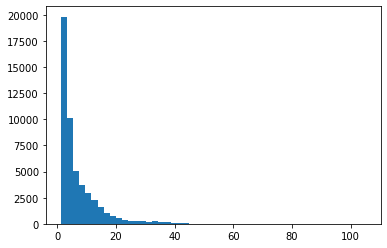

In [34]:
# Plot the distribution of the target variable (canopy height). If a random sample is taken,
# samples should be representative of varying heights
plt.hist(y_train, bins=50)

In [ ]:
# Train a Conformal Quantile Regression (CQR) model (Method 1)
# In this approach, model are first trained with three quantile levels.
# The trained models are provided to the mapie quantile regressor

# alphas = [0.025, 0.975, 0.5] #quantiles (must be in this order- lower, upper, 0.5)
# models = []
# for a in alphas:
#     m = LGBMRegressor(random_state=42, objective='quantile', alpha = a)
#     m.fit(X_train, y_train.values.ravel())
#     models.append(m)
# cqr = MapieQuantileRegressor(models, alpha=0.05, cv="prefit")
# cqr.fit(X_cal, y_cal.values.ravel())
# y_pred, y_pis = cqr.predict(X_test)
# # Compute the distances of upper and lower bounds
# widths = y_pis[:,1] - y_pis[:,0]
# plt.hist(widths, bins = 40)
# plt.hist(y_test, bins = 40)
# plt.hist(y_pred, bins = 40)
# # Label the x-axis
# plt.xlabel("Interval width")
# # Label the y-axis
# plt.ylabel("Frequency")
# plt.show()

# size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
# print("Avg. interval size: {:.2f}".format(size))
# cov = regression_coverage_score(y_test.values.ravel(), y_pis[:,0], y_pis[:,1])
# print("Coverage: {:.2%}".format(cov))

Avg. interval size: 8.92
Coverage: 95.74%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 4
[LightGBM] [Info] Start training from score 2.390000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 4
[LightGBM] [Info] Start training from score 28.760262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

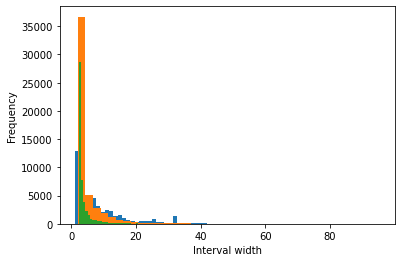

Avg. interval size: 8.92
Coverage: 95.74%


In [41]:
# Train a conformal quantile regression model (method 2)
# In this approach, mapiequantile regressor is only prvided the data. it will train the required models.
regressor = LGBMRegressor(random_state=42, objective='quantile', alpha = 0.5)
mapie = MapieQuantileRegressor(estimator=regressor, cv="split", alpha = 0.05)
mapie.fit(X_train, y_train.values.ravel(), X_calib=X_cal, y_calib=y_cal.values.ravel())
y_pred, y_pis = mapie.predict(X_test)

# Compute the distances of upper and lower bounds
widths = y_pis[:,1] - y_pis[:,0]
plt.hist(widths, bins = 40)
plt.hist(y_test, bins = 40)
plt.hist(y_pred, bins = 40)
# Label the x-axis
plt.xlabel("Interval width")
# Label the y-axis
plt.ylabel("Frequency")
plt.show()

size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
print("Avg. interval size: {:.2f}".format(size))
cov = regression_coverage_score(y_test.values.ravel(), y_pis[:,0], y_pis[:,1])
print("Coverage: {:.2%}".format(cov))

In [26]:
# Save the model for future use
from joblib import dump, load
dump(mapie, r'C:\Users\coach\myfiles\postdoc\Uncertainty\models\CQR_GEDIHeight07122023.joblib')

['C:\\Users\\coach\\myfiles\\postdoc\\Uncertainty\\models\\CQR_GEDIHeight07122023.joblib']

### Inference

The inference function below is able to estimate canopy height and quantify uncertainty for any planet VNIR image. The function parralises on image chips of size patchSize.

In [27]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster

# Parralel processing
import concurrent.futures
import threading
import logging
from tqdm.auto import tqdm
from pathlib import Path
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
def inference(infile: str, confModel, outfile : str, patchSize : int, num_workers : int = 4):
        """
        Run inference on infile (Geotiff) using trained model.

        Args:
            infile (str): A complete path to an image to perform inference on.
            confModel (mapie classifier): Calibrated conformal predictor based on the MAPIE package.
            outfile (str): File path and file name to save output geoTiff files
            patchSize (int): The height and width dimensions of the patch to process
            num_workers (int): The number of core to utilise during parralel processing

        Returns:
            multiband (n_classes +2) geotiff in 'all' mode.
            1) A multiband (number of bands equal to the n classes) geotiff ('set'),
            2) A single band geotiff for highest probability (argmax) class ('predict'),
            3) A single band geotiff for the probability of the argmax class ('predict_proba')

        """

        with rasterio.open(infile) as src:
            
            logger = logging.getLogger(__name__)

            # Create a destination dataset based on source params. The
            # destination will be tiled, and the tiles will be processed
            # concurrently.
            profile = src.profile
            profile.update(blockxsize= patchSize, blockysize= patchSize, tiled=True, count =4)

            with rasterio.open(Path(outfile), "w", **profile) as dst:
                windows = [window for ij, window in dst.block_windows()]

                # use a lock to protect the DatasetReader/Writer
                read_lock = threading.Lock()
                write_lock = threading.Lock()

                def process(window):
                    with read_lock:
                        src_array = src.read(window=window)
                        i_arr = reshape_as_image(src_array)
                        
                        #Format input_image for inference
                        nPixels = i_arr.shape[0]*i_arr.shape[1]
                        nBands = i_arr.shape[-1]
                        # Take full image and reshape into long 2d array (nrow * ncol, nband) for classification
                        new_arr = i_arr.reshape(nPixels, nBands)#reshape 3d array to 2d array that matches the training data table from earlier
                        bandnames = list(src.descriptions)
                        data = pd.DataFrame(new_arr, columns = bandnames).fillna(0)
                        y_pred, y_pis = confModel.predict(data)
                        y_pis = np.squeeze(y_pis, axis=-1)
                        # Compute the distances of upper and lower bounds
                        lower_bound = y_pis[:,0]
                        upper_bound = y_pis[:,1]
                        width =  upper_bound-lower_bound

                        # Reshape our outputs back into a 2D matrix so we can save it as an image
                        result = y_pred.reshape([i_arr.shape[0],i_arr.shape[1]]).astype(np.float64)
                        width = width.reshape([i_arr.shape[0],i_arr.shape[1]]).astype(np.float64)
                        
                        lower_bound = lower_bound.reshape([i_arr.shape[0],i_arr.shape[1]]).astype(np.float64)
                        upper_bound = upper_bound.reshape([i_arr.shape[0],i_arr.shape[1]]).astype(np.float64)
                        
                        dst.descriptions = tuple(['height', 'pred_width', 'lower', 'upper'])
                    with write_lock:
                        for index, filename in enumerate([result, width, lower_bound, upper_bound], start=1):
                            dst.write(filename, window= window, indexes=index)
                        # dst.write(width, window=window, indexes=1)

                # We map the process() function over the list of windows.
                with tqdm(total=len(windows), desc = os.path.basename(outfile)) as pbar:
                    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                        futures = {executor.submit(process, window): window for window in windows}
                        try:
                            for future in concurrent.futures.as_completed(futures):
                                future.result()
                                pbar.update(1)

                        except Exception as ex:
                            logger.info('Cancelling...')
                            executor.shutdown(wait=False, cancel_futures=True)
                            raise ex

In [28]:
# Sanity check before running all images- Perform inference for a single planet image
infile = r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\planet\010.tif"
outfile = r"C:\Users\coach\myfiles\postdoc\Uncertainty\width_010.tif"
inference(infile = infile, confModel = mapie, outfile = outfile, patchSize = 32, num_workers = 10)

width_010.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

In [32]:
# Directory containing the files
directory_path = r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\planet"

# List all files in the directory
files = [f for f in os.listdir(directory_path) if f.endswith('.tif')]

# Specify the common part of the output path
output_directory = r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\planet\predictions"

# Iterate through each file and run the inference
for file in tqdm(files):
    infile = os.path.join(directory_path, file)
    outfile = os.path.join(output_directory, f"width_{file}")
    
    # Run the inference function for each file
    inference(infile=infile, confModel=mapie, outfile=outfile, patchSize=32, num_workers=10)

  0%|          | 0/167 [00:00<?, ?it/s]

width_001.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_002.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_003.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_004.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_005.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_006.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_007.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_008.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_009.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_010.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_011.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_012.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_013.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_014.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_015.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_016.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_017.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_018.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_019.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_020.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_021.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_022.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_023.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_024.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_025.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_026.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_027.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_028.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_029.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_030.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_031.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_032.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_033.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_034.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_035.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_036.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_037.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_038.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_039.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_040.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_041.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_042.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_043.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_044.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_045.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_046.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_047.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_048.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_049.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_050.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_051.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_052.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_053.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_054.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_055.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_056.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_057.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_058.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_059.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_060.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_061.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_062.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_063.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_064.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_065.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_066.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_067.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_068.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_069.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_070.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_071.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_072.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_073.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_074.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_075.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_076.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_077.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_078.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_079.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_080.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_081.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_082.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_083.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_084.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_085.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_086.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_087.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_088.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_089.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_090.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_091.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_092.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_093.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_094.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_095.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_096.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_097.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_098.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_099.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_100.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_101.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_102.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_103.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_104.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_105.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_106.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_107.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_108.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_109.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_110.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_111.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_112.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_113.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_114.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_115.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_116.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_117.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_118.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_119.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_120.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_121.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_122.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_123.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_124.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_125.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_126.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_127.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_128.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_129.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_130.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_131.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_132.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_133.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_134.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_135.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_136.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_137.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_138.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_139.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_140.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_141.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_142.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_143.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_144.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_145.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_146.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_147.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_148.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_149.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_150.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_151.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_152.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_153.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_154.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_155.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_156.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_157.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_158.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_159.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_160.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_161.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_162.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_163.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_164.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_165.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_166.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

width_167.tif:   0%|          | 0/19600 [00:00<?, ?it/s]

### Evaluate CQR model performance on test set

In [6]:
# load saved model
mapie = load(r'C:\Users\coach\myfiles\postdoc\Uncertainty\models\CQR_GEDIHeight07122023.joblib') 
# mapie = load(r'C:\Users\coach\myfiles\postdoc\Uncertainty\models\CQR_GEDIHeight09012024.joblib') 

# Load test data in two dataframes. one for the predictors and the other for the response
base_directory = r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\subAfrica" 
X_test = pd.read_feather(os.path.join(base_directory,"test.feather"), columns = ['B', 'G', 'R', 'N']).dropna()
y_test = pd.read_feather(os.path.join(base_directory,"test.feather"), columns = ['target']).dropna()


C:\Users\coach\AppData\Roaming\Python\Python39\site-packages\mapie\utils.py:519: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
C:\Users\coach\AppData\Roaming\Python\Python39\site-packages\mapie\utils.py:537: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


          y_true  point prediction     lower      upper
8869077     2.62         18.915884  4.076259  35.578783
12079111    3.01          2.987012  2.403747   4.913617
12519892    2.35          2.747732  2.327661  29.855461
24726524    3.40          2.738067  2.318943   6.561214
26625525   10.36          2.810425  2.304429  28.868997


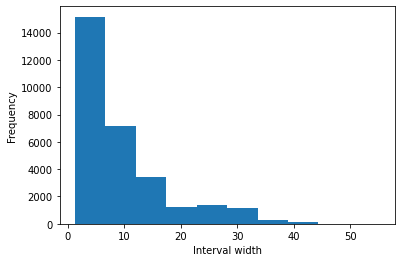

Avg. interval size: 9.03
Coverage: 78.82%


In [7]:
# Load model if needed
# mapie = load(r'C:\Users\coach\myfiles\postdoc\Uncertainty\models\CQR_GEDIHeight07122023.joblib') 

# Take a sample of the test set - faster
nSamples = 300000
# make predictions
y_pred, y_pis = mapie.predict(X_test.sample(nSamples, random_state=44))#

# Create a dataframe of results
predictions = y_test.copy().sample(nSamples)
predictions.columns = ['y_true']
predictions["point prediction"] = y_pred
predictions["lower"] = y_pis.reshape(-1,2)[:,0]
predictions[predictions["lower"]<0]=0
predictions["upper"] = y_pis.reshape(-1,2)[:,1]
predictions[predictions["upper"]<0]=0
# take a quick look
print(predictions.head())

# Compute the distances of upper and lower bounds
widths = y_pis[:,1] - y_pis[:,0]
plt.hist(widths)
# Label the x-axis
plt.xlabel("Interval width")
# Label the y-axis
plt.ylabel("Frequency")
plt.show()

# Compute evaluation scores- average width and marginal coverage
size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
print("Avg. interval size: {:.2f}".format(size))
cov = regression_coverage_score(predictions['y_true'], y_pis[:,0], y_pis[:,1])
print("Coverage: {:.2%}".format(cov))

(array([1.0000e+00, 2.7577e+04, 8.7040e+03, 3.6790e+03, 2.5420e+03,
        1.7460e+03, 8.6100e+02, 5.4700e+02, 4.7700e+02, 7.5800e+02,
        6.0600e+02, 2.8700e+02, 2.4300e+02, 2.1200e+02, 2.2700e+02,
        3.3900e+02, 1.3100e+02, 1.0700e+02, 9.3000e+01, 5.8000e+01,
        6.1000e+01, 6.0000e+01, 5.0000e+01, 4.7000e+01, 6.7000e+01,
        4.6000e+01, 4.3000e+01, 3.5000e+01, 4.3000e+01, 4.1000e+01,
        4.9000e+01, 4.5000e+01, 4.7000e+01, 3.8000e+01, 3.4000e+01,
        3.2000e+01, 2.9000e+01, 2.1000e+01, 1.2000e+01, 5.0000e+00]),
 array([ 1.53973275,  2.27153998,  3.00334721,  3.73515444,  4.46696167,
         5.1987689 ,  5.93057612,  6.66238335,  7.39419058,  8.12599781,
         8.85780504,  9.58961227, 10.3214195 , 11.05322673, 11.78503396,
        12.51684119, 13.24864842, 13.98045565, 14.71226288, 15.44407011,
        16.17587734, 16.90768457, 17.6394918 , 18.37129903, 19.10310626,
        19.83491348, 20.56672071, 21.29852794, 22.03033517, 22.7621424 ,
        23.49394

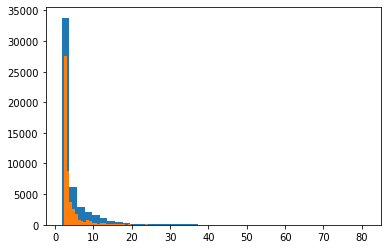

In [15]:
# Histogram plot of the predictions with the reference values
plt.hist(predictions['y_true'], bins=40)
# plt.hist(predictions['y_true']-predictions['point prediction'], bins=40)
plt.hist(predictions['point prediction'], bins=40)

ValueError: 'yerr' must not contain negative values

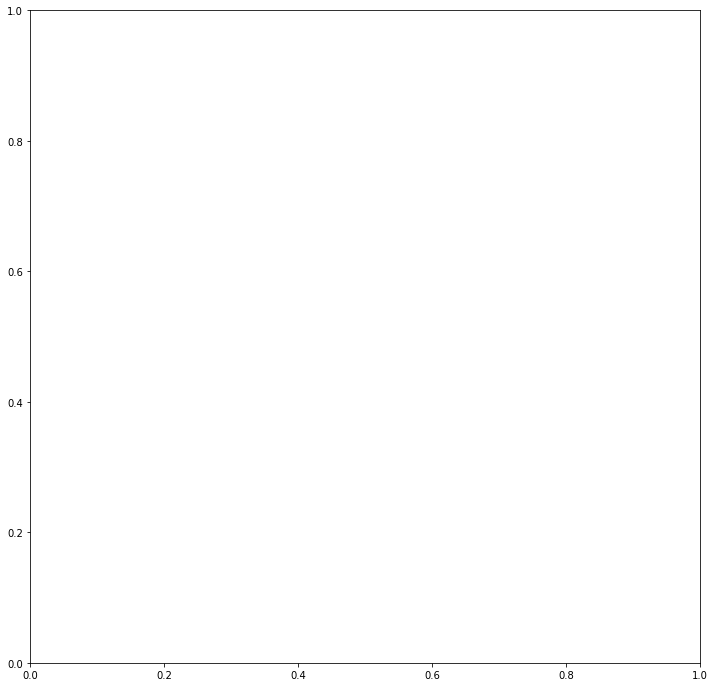

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.errorbar(predictions["y_true"], predictions["point prediction"], 
             yerr=(predictions["point prediction"]-predictions["lower"], predictions["upper"]-predictions["point prediction"]),
             ecolor='grey', linestyle='', marker = "o", capsize=5)

ax.axline([0, 0], [1, 1], color = "red", linestyle='--', lw=3, zorder=3)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Canopy tree height (m)')
plt.ylabel('Predicted canopy tree height (m)')
plt.show()

In [11]:
predictions["error"] = predictions["point prediction"] - predictions["y_true"]

predictions["error_upper"] =   (predictions["upper"] - predictions["point prediction"])
predictions["error_lower"] =  -(predictions["point prediction"] - predictions["lower"])

# sort by total interval width
predictions["interval_width"] = predictions["upper"] - predictions["lower"]
sorted_predictions = predictions.sort_values(by=['interval_width']).reset_index(drop=True)

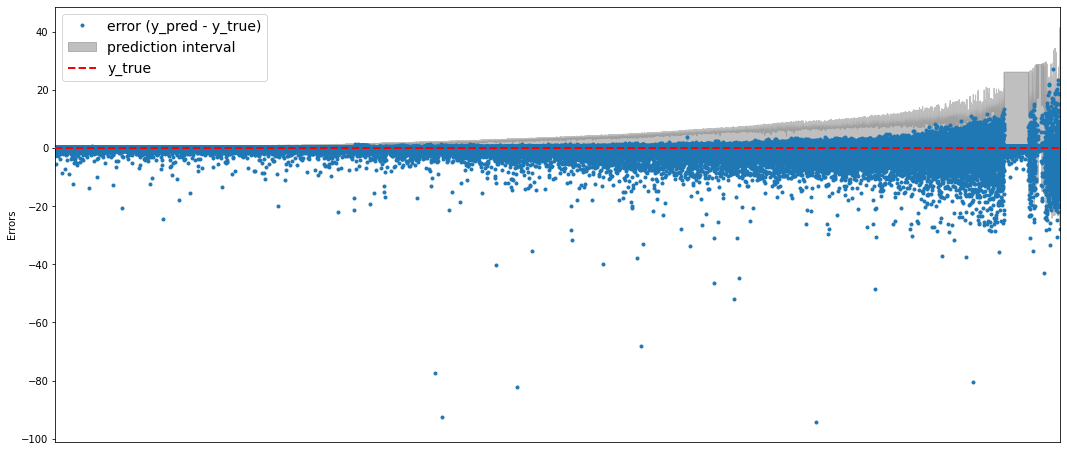

In [12]:
# Plot error against prediction intervals
fig, ax = plt.subplots(figsize=(18, 8))

plt.plot(sorted_predictions["error"], 'o', markersize=3, label="error (y_pred - y_true)")

plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["error_lower"], 
                 sorted_predictions["error_upper"], 
                 alpha=0.5, color="grey", label="prediction interval")

ax.axline([0, 0], [1, 0], color = "red", linestyle='--', lw=2, zorder=3, label="y_true")
plt.xticks([])
plt.xlim([0, len(sorted_predictions)])
plt.ylabel("Errors")
plt.legend(loc="upper left", fontsize=14)
plt.show()